In [260]:
import pandas as pd

df_events = pd.read_csv('/Users/bo/Downloads/subscriber_events.csv')

In [261]:
df_events

,SubscriberKey,Event,Domain,Timestamp,JobID
0,aaron02@example.org,unsub,example.org,2024-04-25 00:20:48.898632,442411
1,aaron30@example.org,click,example.org,2024-04-28 10:08:46.575807,355427
2,aaron30@example.org,unsub,example.org,2024-04-28 10:08:46.575807,964505
3,aaron85@example.org,open,example.org,2024-04-10 17:35:42.060171,701968
4,aaron85@example.org,unsub,example.org,2024-04-10 17:35:42.060171,217868
...,...,...,...,...,...
4009,zwise@example.net,sent,example.net,2024-04-09 19:00:34.543371,795586
4010,zwise@example.net,click,example.net,2024-04-09 19:02:56.543371,334812
4011,zwise@example.net,open,example.net,2024-04-09 19:56:56.543371,577041
4012,zwise@example.net,open,example.net,2024-04-09 20:25:56.543371,217868


In [262]:
# Calculate scores for each event type in event_data
df_events['open_score'] = df_events.apply(lambda row: 2 if row['Event'] == 'open' else 0, axis=1)
df_events['click_score'] = df_events.apply(lambda row: 5 if row['Event'] == 'click' else 0, axis=1)
df_events['sent_score'] = df_events.apply(lambda row: 1 if row['Event'] == 'sent' else 0, axis=1)
df_events['bounce_score'] = df_events.apply(lambda row: -1 if row['Event'] == 'bounce' else 0, axis=1)
df_events['unsub_score'] = df_events.apply(lambda row: -2 if row['Event'] == 'unsub' else 0, axis=1)
df_events['complaint_score'] = df_events.apply(lambda row: -2 if row['Event'] == 'complaint' else 0, axis=1)

df_events['Timestamp'] = pd.to_datetime(df_events['Timestamp'])
df_events['week_of_year'] = df_events['Timestamp'].dt.isocalendar().week
df_events['start_of_week'] = df_events['Timestamp'].dt.to_period('W').dt.start_of



In [263]:
distinct_subscribers = df_events.drop_duplicates('SubscriberKey', keep='last')[['SubscriberKey','Domain']]


In [264]:
distinct_subscribers['open_score'] = distinct_subscribers['SubscriberKey'].map(df_events.groupby('SubscriberKey')['open_score'].sum())
distinct_subscribers['click_score'] = distinct_subscribers['SubscriberKey'].map(df_events.groupby('SubscriberKey')['click_score'].sum())
distinct_subscribers['sent_score'] = distinct_subscribers['SubscriberKey'].map(df_events.groupby('SubscriberKey')['sent_score'].sum())
distinct_subscribers['unsub_score'] = distinct_subscribers['SubscriberKey'].map(df_events.groupby('SubscriberKey')['unsub_score'].sum())
distinct_subscribers['bounce_score'] = distinct_subscribers['SubscriberKey'].map(df_events.groupby('SubscriberKey')['bounce_score'].sum())
distinct_subscribers['complaint_score'] = distinct_subscribers['SubscriberKey'].map(df_events.groupby('SubscriberKey')['complaint_score'].sum())

In [265]:
distinct_subscribers['eses_score'] =  df_events['sent_score'] + df_events['open_score'] + distinct_subscribers['click_score'] + distinct_subscribers['unsub_score']+distinct_subscribers['bounce_score']+distinct_subscribers['complaint_score']

In [266]:
# Calculate the average eses_score
average_eses_score = distinct_subscribers['eses_score'].mean();

# Segment the subscribers based on eses_score
distinct_subscribers['segments'] = pd.cut(distinct_subscribers['eses_score'], bins=[-5, -1, 20, 40, 100], labels=['Unengaged', 'Less Engaged', 'Moderately Engaged', 'Highly Engaged'])

# Calculate the percentage of subscribers in each segment
segment_counts = distinct_subscribers['segments'].value_counts(normalize=True) * 100

# Assign a health score to the database
if (segment_counts['Highly Engaged'] >= 70) and (segment_counts['Unengaged'] <= 10):
	health_score = 'Healthy'
elif (segment_counts['Highly Engaged'] >= 40) and (segment_counts['Highly Engaged'] < 70) and (segment_counts['Unengaged'] >= 10) and (segment_counts['Unengaged'] < 20):
	health_score = 'Neutral'
else:
	health_score = 'At-Risk'

print('Average ESES Score:', average_eses_score)
print('Max ESES Score:', distinct_subscribers['eses_score'].max())
print('Min ESES Score:', distinct_subscribers['eses_score'].min())
print('Segment Counts:', segment_counts)
print('Health Score:', health_score)

Average ESES Score: 3.1715145436308925
Max ESES Score: 53.0
Min ESES Score: -4.0
Segment Counts: segments
Unengaged             48.445336
Less Engaged          48.345035
Moderately Engaged     3.109328
Highly Engaged         0.100301
Name: proportion, dtype: float64
Health Score: At-Risk


In [267]:
# Scale the average ESES score to a 0-100 range
max_eses_score =  distinct_subscribers['eses_score'].max()
scaled_score = (average_eses_score / max_eses_score) * 100

print('Average ESES Score (scaled):', scaled_score)

Average ESES Score (scaled): 5.983989704963948


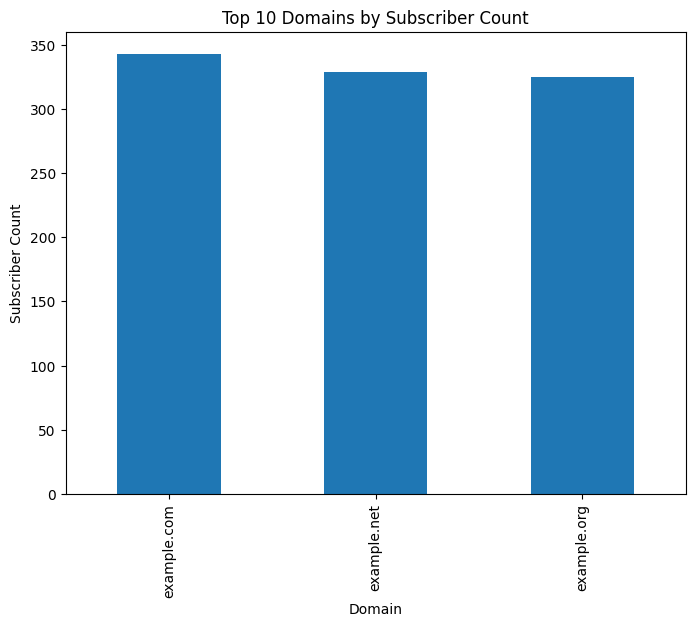

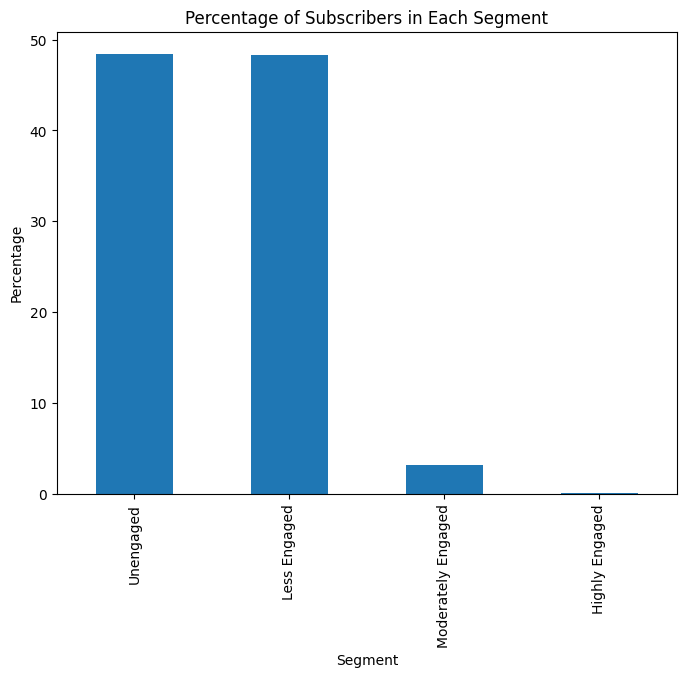

In [268]:
import matplotlib.pyplot as plt
top_domains = distinct_subscribers['Domain'].value_counts().head(10)

# Plot a chart to display the percentage of health braces per domain
plt.figure(figsize=(8, 6))
top_domains.plot(kind='bar')
plt.title('Top 10 Domains by Subscriber Count')
plt.xlabel('Domain')
plt.ylabel('Subscriber Count')
plt.show()

# Plot a chart to display the percentage of health braces per segment
plt.figure(figsize=(8, 6))
segment_counts.plot(kind='bar')
plt.title('Percentage of Subscribers in Each Segment')
plt.xlabel('Segment')
plt.ylabel('Percentage')
plt.show()

In [269]:
weekly_stats = df_events.groupby('start_of_week')[['sent_score','open_score','click_score','unsub_score','bounce_score','complaint_score']].sum()

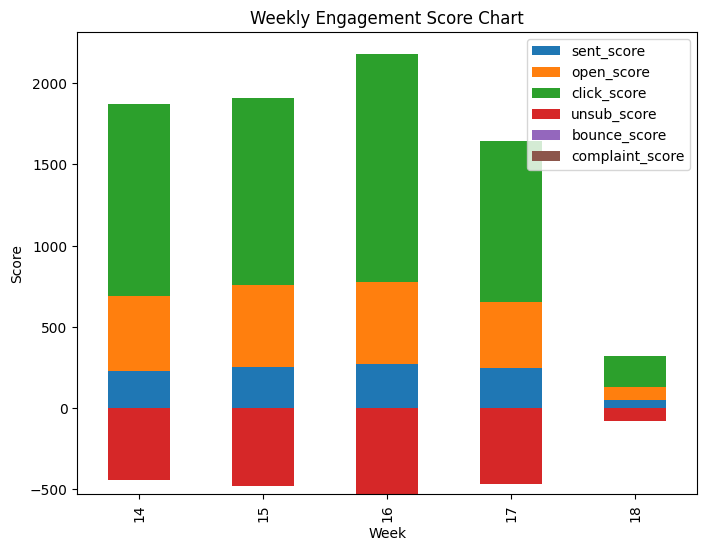

In [270]:
df = pd.DataFrame(weekly_stats)

# Plot a stacked bar chart
df.plot(kind='bar', stacked=True, figsize=(8, 6))

# Add a title and labels
plt.title('Weekly Engagement Score Chart')
plt.xlabel('Week')
plt.ylabel('Score')

# Show the plot
plt.show()